In [13]:
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os

load_dotenv()
conn = psycopg2.connect(
    host=os.getenv("PG_HOST"),
    database=os.getenv("PG_DB"),
    user=os.getenv("PG_USER"),
    password=os.getenv("PG_PASSWORD"),
    port=os.getenv("PG_PORT"),
    sslmode="require",
)

/var/folders/w9/l6ytrz8n6rj5x7t50scbcvkm0000gn/T/ipykernel_79158/1768144476.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  possession_df = pd.read_sql_query(
/var/folders/w9/l6ytrz8n6rj5x7t50scbcvkm0000gn/T/ipykernel_79158/1768144476.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  spadl_actions = pd.read_sql_query(
/var/folders/w9/l6ytrz8n6rj5x7t50scbcvkm0000gn/T/ipykernel_79158/1768144476.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  home_team = pd.read_sql_query(


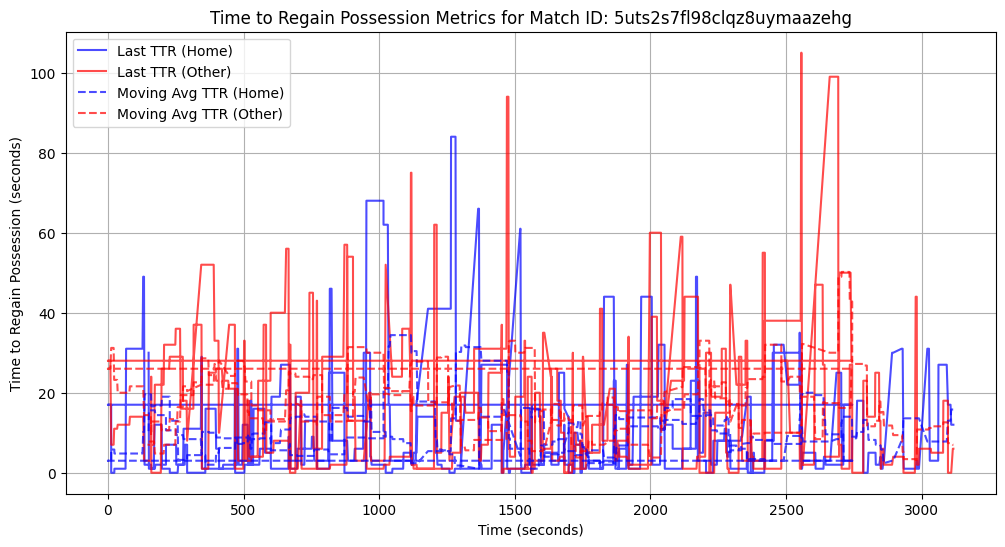

Processed SPADL actions for match_id: 5uts2s7fl98clqz8uymaazehg
Showing rows starting from the first values where 'last_ttr_home' and 'last_ttr_other' are non-NaN, and 'mavg_ttr_home' and 'mavg_ttr_other' are greater than 0:
       id  period_id  seconds    player_name                    team_id  \
58  25192          1    150.0      D. Yokota  8y3iucyxguipljcmf87a11bk9   
59  25193          1    151.0      D. Hrnčár  4dtif7outbuivua8umbwegoo5   
60  25194          1    153.0    T. Watanabe  8y3iucyxguipljcmf87a11bk9   
61  25195          1    156.0      N. Fadiga  8y3iucyxguipljcmf87a11bk9   
62  25196          1    159.0      N. Fadiga  8y3iucyxguipljcmf87a11bk9   
63  25197          1    161.0  A. Guðjohnsen  8y3iucyxguipljcmf87a11bk9   
64  25198          1    162.5        S. Kums  8y3iucyxguipljcmf87a11bk9   
65  25199          1    164.0        S. Kums  8y3iucyxguipljcmf87a11bk9   
66  25200          1    165.5       A. Brown  8y3iucyxguipljcmf87a11bk9   
67  25201          1    1

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

match_id = "5uts2s7fl98clqz8uymaazehg"

# Load possession data
possession_df = pd.read_sql_query(
    f"""
    WITH action_changes AS (
        SELECT  a.*,
                LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
                LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
        FROM spadl_actions a
        WHERE a.game_id = '{match_id}'
    ),
    possession_markers AS (
        SELECT  *,
                CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
        FROM action_changes
    ),
    possession_sequences AS (
        SELECT  *,
                SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_group
        FROM possession_markers
    )
    SELECT  a.*,
            t.team_id AS team_losing_possession,
            nt.team_id AS team_gaining_possession
    FROM possession_sequences a
    JOIN teams t ON a.team_id = t.team_id
    LEFT JOIN teams nt ON a.next_team_id = nt.team_id
    WHERE a.team_id != a.next_team_id AND a.next_team_id IS NOT NULL  
    ORDER BY a.period_id, a.seconds, a.id;
    """,
    conn,
)

# Load spadl_actions with player_name
spadl_actions = pd.read_sql_query(
    f"""
    SELECT 
        sa.*,
        p.player_name
    FROM spadl_actions sa
    JOIN players p ON sa.player_id = p.player_id
    WHERE sa.game_id = '{match_id}'
    """,
    conn
)

# Load home team
home_team = pd.read_sql_query(
    f"SELECT home_team_id FROM matches WHERE match_id = '{match_id}'", conn
).squeeze()

# Initialize columns
spadl_actions[["mavg_ttr_home", "mavg_ttr_other", "last_ttr_home", "last_ttr_other"]] = np.nan
spadl_actions["possessing_team"] = None

# Process possession data
for period_id in possession_df["period_id"].unique():
    last_possession = {}
    for _, possession in possession_df[
        possession_df["period_id"] == period_id
    ].iterrows():
        team_losing = possession["team_losing_possession"]
        team_gaining = possession["team_gaining_possession"]
        last_possession[team_gaining] = possession["seconds"]
        if team_losing in last_possession:
            possessing_team = "home" if team_gaining == home_team else "other"
            last_ttr = last_possession[team_gaining] - last_possession[team_losing]

            mavg_ttr = (
                spadl_actions[f"last_ttr_{possessing_team}"]
                .dropna()
                .rolling(5)
                .mean()
            )

            if len(mavg_ttr) == 0:
                mavg_ttr = 0
            else:
                mavg_ttr = mavg_ttr.iloc[-1]

            spadl_actions.loc[
                spadl_actions["id"] == possession["id"],
                [
                    "possessing_team",
                    f"last_ttr_{possessing_team}",
                    f"mavg_ttr_{possessing_team}",
                ],
            ] = [possessing_team, last_ttr, mavg_ttr]

residual_columns = ["last_ttr_home", "last_ttr_other", "mavg_ttr_home", "mavg_ttr_other", "possessing_team"]
spadl_actions[residual_columns] = spadl_actions[residual_columns].ffill()


mask = (
    spadl_actions['last_ttr_home'].notna() &
    spadl_actions['last_ttr_other'].notna() &
    (spadl_actions['mavg_ttr_home'] > 0) &
    (spadl_actions['mavg_ttr_other'] > 0)
)
first_valid_index = spadl_actions[mask].index[0] if mask.any() else None

if first_valid_index is not None:
    spadl_actions_filtered = spadl_actions.loc[first_valid_index:]
else:
    spadl_actions_filtered = spadl_actions  # If no valid rows, keep the original DataFrame

plt.figure(figsize=(12, 6))

plt.plot(spadl_actions_filtered['seconds'], spadl_actions_filtered['last_ttr_home'], label='Last TTR (Home)', color='blue', linestyle='-', alpha=0.7)
plt.plot(spadl_actions_filtered['seconds'], spadl_actions_filtered['last_ttr_other'], label='Last TTR (Other)', color='red', linestyle='-', alpha=0.7)

plt.plot(spadl_actions_filtered['seconds'], spadl_actions_filtered['mavg_ttr_home'], label='Moving Avg TTR (Home)', color='blue', linestyle='--', alpha=0.7)
plt.plot(spadl_actions_filtered['seconds'], spadl_actions_filtered['mavg_ttr_other'], label='Moving Avg TTR (Other)', color='red', linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Time to Regain Possession (seconds)')
plt.title(f'Time to Regain Possession Metrics for Match ID: {match_id}')
plt.legend()
plt.grid(True)

plt.show()

relevant_columns = [
    'id', 'period_id', 'seconds', 'player_name', 'team_id', 
    'possessing_team', 'last_ttr_home', 'last_ttr_other', 
    'mavg_ttr_home', 'mavg_ttr_other'
]

spadl_actions_filtered = spadl_actions_filtered[relevant_columns]

print(f"Processed SPADL actions for match_id: {match_id}")
print(f"Showing rows starting from the first values where 'last_ttr_home' and 'last_ttr_other' are non-NaN, and 'mavg_ttr_home' and 'mavg_ttr_other' are greater than 0:")
print(spadl_actions_filtered.head(10))